# IBM Data Science Capstone Project

This notebook will guide you through a theoretical business problem. The question that we are trying to answer is the following:
A successful owner of multiple mid-high-end restaurants decided to open a new restaurant in Budapest, Hungary. Having visited the city many times in the recent years, he couldn't disregard the big boom in gastronomy in the city. He is keen on opening a new unit which will focus on the European and Asian fusion kitchen. 

Taking into account the price level that the restaurant will operate, the intent is to find an optimal place in an area, where gastronomy is booming and easily accessible for tourists and for wealthier local citizens as well.

Assumptions, business logic:
The assumption behind the analysis is that we can use unsupervised machine learning to create clusters of districts that will provide us a list of areas for consideration for the restaurant. The intent is that the restaurant to be situated close one of the gastronomical centers.

To do this, we will need the following data:
1. List of the districts of Budapest -> this comes from a csv list
2. Geo-coordinates of the districts in Budapest -> this is obtained via geocoder
3. Top venues of districts -> Foursquare API is used to collect the venue data

Methodology:
After tidying up the data, we will apply K-means machine learning technique for creating clusters of districts. We will use silhouette score for choosing the optimal number of clusters.

Limitations:
The analysis has some limitations that should be taken into account. Some limitations:
1. The analysis is performed on 17 of the 23 districts in Budapest. That is due to technical limitations with geocoder.
2. The analsiss is performed on a district level.
3. When collecting venues a 1000 meter radius is used around the center coordinates of the districts. The number of collected venues is limited to 100 per districts.




### Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library


print('Libraries imported.')

Libraries imported.


# 1. Putting the Data together

## Budapest Districts

We get the list of districts from a csv file. There are 23 districts in Budapest and they are numbered, and not all of them have a name.

In [2]:
df_data_1=pd.read_html('https://en.wikipedia.org/wiki/List_of_districts_in_Budapest')[1]
df_data_1=df_data_1.rename(columns={0:'District',1:'Name',2:'Neighborhoods',3:'Sights'})
df_data_1.dropna(inplace=True)
df_data_1.head()

,District,Name,Population (2016),Area (km2),Population density (people per km2)
0,I. kerület,"Várkerület (""Castle District"")",25196,3.41,7388.8
1,II. kerület,-,89903,36.34,2473.9
2,III. kerület,"Óbuda-Békásmegyer (""Old Buda-Békásmegyer"")",130415,39.70,3285.0
3,IV. kerület,"Újpest (""New Pest"")",101558,18.82,5396.2
4,V. kerület,"Belváros-Lipótváros (""Inner City - Leopold Town"")",26284,2.59,10148.2


Creating the dataframe which will contain latitude and longitude data

In [3]:
# define the dataframe columns
column_names = ['District', 'Name', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighbors = pd.DataFrame(columns=column_names)

neighbors

,District,Name,Latitude,Longitude


Getting the geo-coordinates for the districts

In [4]:
from geopy.geocoders import Nominatim
district = df_data_1['District']
name = df_data_1['Name']
location = None
latitude = None
longitude = None

for data in range(0, len(district)):
    dt = district[data]
    nm = name[data]
    
    geolocator = Nominatim(user_agent="my-application6543")
    location = geolocator.geocode('{}'.format(dt))
    latitude = location.latitude
    longitude = location.longitude

    neighbors = neighbors.append({ 'District':dt,'Name':nm,'Latitude': location.latitude,'Longitude': location.longitude}, ignore_index=True)

In [5]:
neighbors

,District,Name,Latitude,Longitude
0,I. kerület,"Várkerület (""Castle District"")",47.499163,19.035143
1,II. kerület,-,47.538887,18.982636
2,III. kerület,"Óbuda-Békásmegyer (""Old Buda-Békásmegyer"")",47.567611,19.036780
3,IV. kerület,"Újpest (""New Pest"")",47.576169,19.095508
4,V. kerület,"Belváros-Lipótváros (""Inner City - Leopold Town"")",47.499945,19.050549
5,VI. kerület,"Terézváros (""Theresa Town"")",47.509494,19.065323
6,VII. kerület,"Erzsébetváros (""Elisabeth Town"")",47.502200,19.075153
7,VIII. kerület,"Józsefváros (""Joseph Town"")",47.490595,19.087340
8,IX. kerület,"Ferencváros (""Francis Town"")",47.465356,19.090356
9,X. kerület,"Kőbánya (""Quarry"")",47.482235,19.156494


In [6]:
neighbors.shape

(24, 4)

As you can notice, we have only 17 districts here and that is due to the error with geocode that failed to retrieve the whole list. I have tried several times, but eventually I decided to proceed with the data I have. Nevertheless, the higher number of districts are mainly outskirts and very unlikely to have a material impact on the analysis.

### Mapping Budapest with the 17 districts

First, let's find the geodata for Budapest

In [7]:
geolocator = Nominatim(user_agent="my-application6554")
location = geolocator.geocode('Budapest')
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinate of Budapest are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Budapest are 47.48138955, 19.14607278448202.


Let's create a map, with showing the districts

In [8]:
map_budapest = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district in zip(neighbors['Latitude'], neighbors['Longitude'], neighbors['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_budapest)  
    
map_budapest

# 2. Exploring the Districts

## Exploring Top District Venues with Foursquare

Foursquare credentials

In [9]:
CLIENT_ID = '5ZN1PMFBHE1JD0V0STPPDUPF551Q5RK15DEU1I1QI5QDUJBV' #  Foursquare ID
CLIENT_SECRET = 'T4DLPCIRTHY0WNXCNRHNIKQ44GQJVIG4UPEFYT2XO1UXZS5I' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5ZN1PMFBHE1JD0V0STPPDUPF551Q5RK15DEU1I1QI5QDUJBV
CLIENT_SECRET:T4DLPCIRTHY0WNXCNRHNIKQ44GQJVIG4UPEFYT2XO1UXZS5I


## Exploring the first District

District is called 'kerület' in Hungarian

In [10]:
neighbors.loc[0, 'District']

'I. kerület'

Getting the district's geo coordinates

In [11]:
neighborhood_latitude = neighbors.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighbors.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighbors.loc[0, 'Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Várkerület ("Castle District") are 47.4991627, 19.0351431.


Getting the top 100 venues that are in I. kerulet (First district) within a radius of 1000 meters.
This will be obtained from Foursquare.

In [12]:
search_query = 'venues'
radius = 1000
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url


'https://api.foursquare.com/v2/venues/explore?&client_id=5ZN1PMFBHE1JD0V0STPPDUPF551Q5RK15DEU1I1QI5QDUJBV&client_secret=T4DLPCIRTHY0WNXCNRHNIKQ44GQJVIG4UPEFYT2XO1UXZS5I&v=20180605&ll=47.4991627,19.0351431&radius=1000&limit=100'

Getting the json of venues

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '600a2ffefbbe710cee801ae7'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Várnegyed',
  'headerFullLocation': 'Várnegyed, Budapest',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 154,
  'suggestedBounds': {'ne': {'lat': 47.50816270900001,
    'lng': 19.048439713229843},
   'sw': {'lat': 47.49016269099999, 'lng': 19.021846486770155}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d46bd852e326ea83a21faa6',
       'name': 'Dísz tér',
       'location': {'address': 'Dísz tér',
        'lat': 47.49909987702406,
        'lng': 19.036163341521213,
        'labeledLatLngs': [{'label': 'display',
          'lat': 47.49909987702406

Defining a function to get categories

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Tidying up the data 

In [15]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

<ipython-input-15-1c028eb8b537>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues)


,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Dísz tér,4d46bd852e326ea83a21faa6,Plaza,47.499100,19.036163
1,Stand25 Bisztró,5dceff35f1c28a0008a4e570,Bistro,47.497673,19.032679
2,Halászbástya | Fisherman's Bastion (Halászbástya),4d298eccc406721e6a537cb6,Historic Site,47.502029,19.035058
3,Budavári Mikve,5adb36dee4c459213da14b2e,Historic Site,47.498546,19.035846
4,Várnegyed,5059c340e4b082424ecc9822,Scenic Lookout,47.501195,19.032261
5,Honda Dream,4c948ab172dd224be9ed9a91,Motorcycle Shop,47.498561,19.031825
6,Sziklakórház (Sziklakórház és Atombunker),4c51a1ab3940be9ae8852e09,History Museum,47.500652,19.031667
7,Várhegy,4c8a556b1dcd199cf464531b,Scenic Lookout,47.497570,19.038747
8,Halászbástya Restaurant,4c72c7ed4bc4236a4330cc7a,Hungarian Restaurant,47.502534,19.034489
9,Alagút-tető,4d908822788c5481e23866fd,Scenic Lookout,47.498166,19.039510


In [16]:
#fix the column names

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,Dísz tér,4d46bd852e326ea83a21faa6,Plaza,47.499100,19.036163
1,Stand25 Bisztró,5dceff35f1c28a0008a4e570,Bistro,47.497673,19.032679
2,Halászbástya | Fisherman's Bastion (Halászbástya),4d298eccc406721e6a537cb6,Historic Site,47.502029,19.035058
3,Budavári Mikve,5adb36dee4c459213da14b2e,Historic Site,47.498546,19.035846
4,Várnegyed,5059c340e4b082424ecc9822,Scenic Lookout,47.501195,19.032261
5,Honda Dream,4c948ab172dd224be9ed9a91,Motorcycle Shop,47.498561,19.031825
6,Sziklakórház (Sziklakórház és Atombunker),4c51a1ab3940be9ae8852e09,History Museum,47.500652,19.031667
7,Várhegy,4c8a556b1dcd199cf464531b,Scenic Lookout,47.497570,19.038747
8,Halászbástya Restaurant,4c72c7ed4bc4236a4330cc7a,Hungarian Restaurant,47.502534,19.034489
9,Alagút-tető,4d908822788c5481e23866fd,Scenic Lookout,47.498166,19.039510


## Now let's explore the other districts as well

for that, let's create a function

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Let's collect the data

In [18]:
budapest_venues = getNearbyVenues(names=neighbors['District'],
                                   latitudes=neighbors['Latitude'],
                                   longitudes=neighbors['Longitude']
                                  )

I. kerület
II. kerület
III. kerület
IV. kerület
V. kerület
VI. kerület
VII. kerület
VIII. kerület
IX. kerület
X. kerület
XI. kerület
XII. kerület
XIII. kerület
XIV. kerület
XV. kerület
XVI. kerület
XVII. kerület
XVIII. kerület
XIX. kerület
XX. kerület
XXI. kerület
XXII. kerület
XXIII. kerület
All


In [19]:
print(budapest_venues.shape)
budapest_venues.head()

(1106, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,I. kerület,47.499163,19.035143,Dísz tér,47.499100,19.036163,Plaza
1,I. kerület,47.499163,19.035143,Stand25 Bisztró,47.497673,19.032679,Bistro
2,I. kerület,47.499163,19.035143,Halászbástya | Fisherman's Bastion (Halászbástya),47.502029,19.035058,Historic Site
3,I. kerület,47.499163,19.035143,Budavári Mikve,47.498546,19.035846,Historic Site
4,I. kerület,47.499163,19.035143,Várnegyed,47.501195,19.032261,Scenic Lookout


Now, checking how many venues were collected for other districts as well. 

In [20]:
budapest_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
All,1,1,1,1,1,1
I. kerület,100,100,100,100,100,100
II. kerület,27,27,27,27,27,27
III. kerület,15,15,15,15,15,15
IV. kerület,29,29,29,29,29,29
IX. kerület,41,41,41,41,41,41
V. kerület,100,100,100,100,100,100
VI. kerület,100,100,100,100,100,100
VII. kerület,100,100,100,100,100,100


### Checking how many distinct venue categories we have

In [21]:
print('There are {} uniques categories.'.format(len(budapest_venues['Venue Category'].unique())))

There are 221 uniques categories.


# 3. Analyzing the Districts

For that, we use one hot encoding.

In [22]:
# one hot encoding
budapest_onehot = pd.get_dummies(budapest_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
budapest_onehot['Neighborhood'] = budapest_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [budapest_onehot.columns[-1]] + list(budapest_onehot.columns[:-1])
budapest_onehot = budapest_onehot[fixed_columns]

budapest_onehot.head()

,Yoga Studio,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Campground,Candy Store,Castle,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hockey Arena,Hockey Rink,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Karaoke Bar,Kebab Restaurant,Kids Store,Light Rail Station,Lingerie Store,Liquor Store,Lottery Retailer,Market,Martial Arts School,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Record Shop,Recreation Center,Restaurant,River,Road,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Stables,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,I. kerület,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,I. kerület,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [23]:
budapest_onehot.shape

(1106, 221)

Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [24]:
budapest_grouped = budapest_onehot.groupby('Neighborhood').mean().reset_index()
budapest_grouped

,Neighborhood,Yoga Studio,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Campground,Candy Store,Castle,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hockey Arena,Hockey Rink,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Karaoke Bar,Kebab Restaurant,Kids Store,Light Rail Station,Lingerie Store,Liquor Store,Lottery Retailer,Market,Martial Arts School,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Music Store,Music Venue,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Other Repair Shop,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Record Shop,Recreation Center,Restaurant,River,Road,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Stables,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop
0,All,0.000000,0.000000,0.000000,0.00000,0.00,0.00,0.000000,0.000000,1.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.00,0.00,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

### Let's see each neighborhood along with the top 5 most common venues

In [25]:
num_top_venues = 5

for hood in budapest_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = budapest_grouped[budapest_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----All----
               venue  freq
0   Asian Restaurant   1.0
1        Yoga Studio   0.0
2           Pharmacy   0.0
3       Optical Shop   0.0
4  Other Repair Shop   0.0


----I. kerület----
         venue  freq
0  Coffee Shop  0.06
1         Café  0.06
2        Hotel  0.06
3       Bakery  0.05
4        Plaza  0.05


----II. kerület----
            venue  freq
0        Bus Stop  0.11
1  Scenic Lookout  0.11
2    Tram Station  0.11
3   Grocery Store  0.07
4            Park  0.07


----III. kerület----
                  venue  freq
0              Bus Stop  0.13
1                Bakery  0.07
2  Fast Food Restaurant  0.07
3         Deli / Bodega  0.07
4                 Plaza  0.07


----IV. kerület----
           venue  freq
0       Bus Stop  0.10
1    Pizza Place  0.07
2   Burger Joint  0.07
3  Grocery Store  0.07
4            Gym  0.03


----IX. kerület----
                  venue  freq
0           Music Venue  0.07
1          Soccer Field  0.07
2         Train Station  0.07
3       

Putting it into a dataframe

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = budapest_grouped['Neighborhood']

for ind in np.arange(budapest_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(budapest_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,All,Asian Restaurant,Wine Shop,Fish & Chips Shop,Furniture / Home Store,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Forest
1,I. kerület,Café,Coffee Shop,Hotel,Hungarian Restaurant,Plaza,Bakery,Historic Site,Scenic Lookout,Park,Pub
2,II. kerület,Scenic Lookout,Bus Stop,Tram Station,Grocery Store,Tennis Court,Park,Track,Multiplex,Campground,Soccer Field
3,III. kerület,Bus Stop,Bar,Auto Garage,Other Repair Shop,Bakery,Fast Food Restaurant,Clothing Store,Track,Light Rail Station,Mountain
4,IV. kerület,Bus Stop,Pizza Place,Burger Joint,Grocery Store,Bakery,Soccer Stadium,Chinese Restaurant,Ski Area,Café,Dog Run


##  Using Machine Learning for Clustering Neighborhoods

For clustering, K-means method will be applied. To be able to select the optimal number of clusters,  the silhouette score will be used.

First, let's find out the optimal number of clusters. For that, we will create a graph of the silhouette scores.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [29]:
max_range = 8

budapest_grouped_clustering = budapest_grouped.drop('Neighborhood', 1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = budapest_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

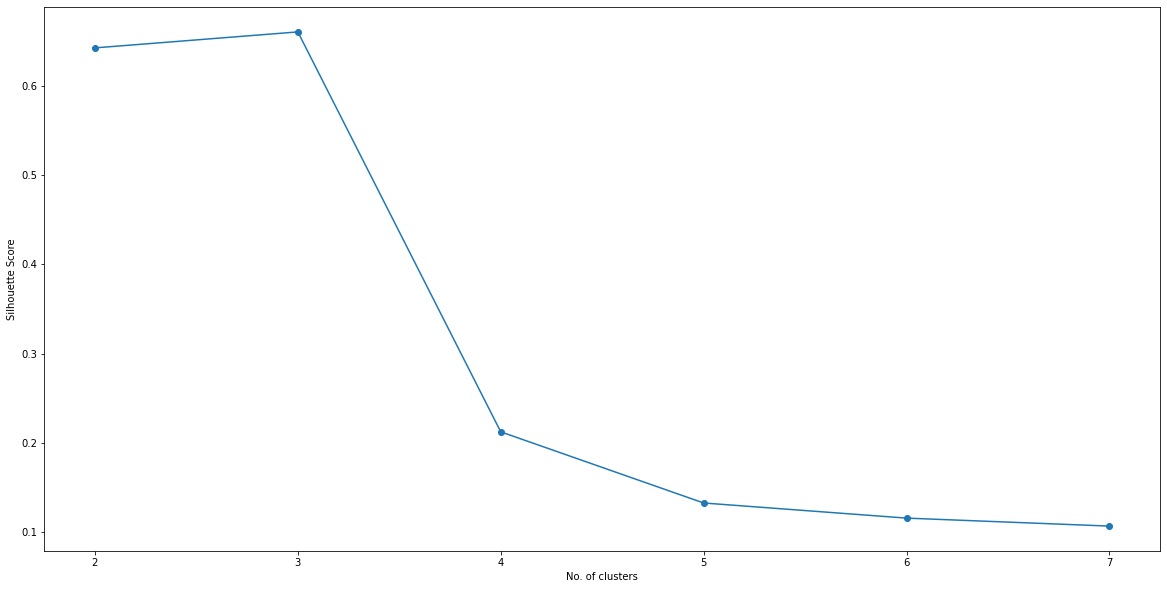

In [30]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

Based on this graph, we can see that the optimal number of clusters is 4.

Now let's run the K-means clustering with the optimal number of clusters, which is 4.

In [31]:
# run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(budapest_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [32]:
neighbors.rename(columns={'District':'Neighborhood'}, inplace=True)
neighbors.head()

,Neighborhood,Name,Latitude,Longitude
0,I. kerület,"Várkerület (""Castle District"")",47.499163,19.035143
1,II. kerület,-,47.538887,18.982636
2,III. kerület,"Óbuda-Békásmegyer (""Old Buda-Békásmegyer"")",47.567611,19.036780
3,IV. kerület,"Újpest (""New Pest"")",47.576169,19.095508
4,V. kerület,"Belváros-Lipótváros (""Inner City - Leopold Town"")",47.499945,19.050549


In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

budapest_merged = neighbors

# merge budapest_grouped with budapest_data to add latitude/longitude for each neighborhood
budapest_merged = budapest_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

budapest_merged

,Neighborhood,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I. kerület,"Várkerület (""Castle District"")",47.499163,19.035143,0,Café,Coffee Shop,Hotel,Hungarian Restaurant,Plaza,Bakery,Historic Site,Scenic Lookout,Park,Pub
1,II. kerület,-,47.538887,18.982636,0,Scenic Lookout,Bus Stop,Tram Station,Grocery Store,Tennis Court,Park,Track,Multiplex,Campground,Soccer Field
2,III. kerület,"Óbuda-Békásmegyer (""Old Buda-Békásmegyer"")",47.567611,19.036780,0,Bus Stop,Bar,Auto Garage,Other Repair Shop,Bakery,Fast Food Restaurant,Clothing Store,Track,Light Rail Station,Mountain
3,IV. kerület,"Újpest (""New Pest"")",47.576169,19.095508,0,Bus Stop,Pizza Place,Burger Joint,Grocery Store,Bakery,Soccer Stadium,Chinese Restaurant,Ski Area,Café,Dog Run
4,V. kerület,"Belváros-Lipótváros (""Inner City - Leopold Town"")",47.499945,19.050549,0,Hotel,Italian Restaurant,Coffee Shop,Hungarian Restaurant,Plaza,Wine Bar,Café,Ice Cream Shop,Dessert Shop,Cosmetics Shop
5,VI. kerület,"Terézváros (""Theresa Town"")",47.509494,19.065323,0,Coffee Shop,Italian Restaurant,Sporting Goods Shop,Pizza Place,Pub,Thai Restaurant,Electronics Store,Hotel,Theater,Theme Park
6,VII. kerület,"Erzsébetváros (""Elisabeth Town"")",47.502200,19.075153,0,Coffee Shop,Hotel,Restaurant,Hungarian Restaurant,Bar,Thai Restaurant,Bakery,Indian Restaurant,Dessert Shop,Theater
7,VIII. kerület,"Józsefváros (""Joseph Town"")",47.490595,19.087340,0,Clothing Store,Coffee Shop,Park,Vietnamese Restaurant,Gym / Fitness Center,Pub,Fast Food Restaurant,Supermarket,Boutique,Bistro
8,IX. kerület,"Ferencváros (""Francis Town"")",47.465356,19.090356,0,Train Station,Soccer Field,Music Venue,Hungarian Restaurant,Furniture / Home Store,Tram Station,Department Store,Clothing Store,Brewery,Mobile Phone Shop
9,X. kerület,"Kőbánya (""Quarry"")",47.482235,19.156494,0,Brewery,Park,Bus Stop,Furniture / Home Store,Bistro,Grocery Store,Gym,Pub,Eastern European Restaurant,Pharmacy


Now, visualizing the clusters

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(budapest_merged['Latitude'], budapest_merged['Longitude'], budapest_merged['Neighborhood'], budapest_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining Clusters

### Cluster 1

In [37]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 0, budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I. kerület,Café,Coffee Shop,Hotel,Hungarian Restaurant,Plaza,Bakery,Historic Site,Scenic Lookout,Park,Pub
1,II. kerület,Scenic Lookout,Bus Stop,Tram Station,Grocery Store,Tennis Court,Park,Track,Multiplex,Campground,Soccer Field
2,III. kerület,Bus Stop,Bar,Auto Garage,Other Repair Shop,Bakery,Fast Food Restaurant,Clothing Store,Track,Light Rail Station,Mountain
3,IV. kerület,Bus Stop,Pizza Place,Burger Joint,Grocery Store,Bakery,Soccer Stadium,Chinese Restaurant,Ski Area,Café,Dog Run
4,V. kerület,Hotel,Italian Restaurant,Coffee Shop,Hungarian Restaurant,Plaza,Wine Bar,Café,Ice Cream Shop,Dessert Shop,Cosmetics Shop
5,VI. kerület,Coffee Shop,Italian Restaurant,Sporting Goods Shop,Pizza Place,Pub,Thai Restaurant,Electronics Store,Hotel,Theater,Theme Park
6,VII. kerület,Coffee Shop,Hotel,Restaurant,Hungarian Restaurant,Bar,Thai Restaurant,Bakery,Indian Restaurant,Dessert Shop,Theater
7,VIII. kerület,Clothing Store,Coffee Shop,Park,Vietnamese Restaurant,Gym / Fitness Center,Pub,Fast Food Restaurant,Supermarket,Boutique,Bistro
8,IX. kerület,Train Station,Soccer Field,Music Venue,Hungarian Restaurant,Furniture / Home Store,Tram Station,Department Store,Clothing Store,Brewery,Mobile Phone Shop
9,X. kerület,Brewery,Park,Bus Stop,Furniture / Home Store,Bistro,Grocery Store,Gym,Pub,Eastern European Restaurant,Pharmacy


### Cluster 2

In [38]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 1, budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,XXIII. kerület,Farm,Wine Shop,Fast Food Restaurant,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Forest,Food Court


### Cluster 3

In [39]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 2, budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,All,Asian Restaurant,Wine Shop,Fish & Chips Shop,Furniture / Home Store,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Forest


### Cluster 4

In [40]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 3, budapest_merged.columns[[0] + list(range(5, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


# 4. Conclusion

### Understanding the Clusters

By looking at the cluster data, we can see that cluster 2 is the one that we are the most interested in. 

Cluster 0 is an outer district where top gastronomy is not really represented (supermarket and fast food are in the top).

Cluster 3 is districts where public travel rated at top, but behind that parks, playgrounds are also present. These are mainly areas with family houses where people live, but not really the vibrant, lively part of the city.

Cluster 4 contain only one district. Here we see restaurant at the top, but behind that it is about public transport. 

Cluster 2 is the biggest cluster, but this is where we see lot's of gastronomy related venues (coffee shop, pizza place, Thai restaurant, beer bar, pub, modern European restaurant, etc..).

Based on that, we can advise the restaurant owner to consider the districts from this cluster as the potential location for the new restaurant.